# Import modules

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [29]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/rfs/project/rfs-iCNyzSAaucw/kk837/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [3]:
figdir = '/rfs/project/rfs-iCNyzSAaucw/kk837/notebooks/Foetal/fetal_ms_figures'
# table_dir = '/nfs/team205/heart/fetal_ms_figures/tables/Aug2024'

# Read in qeury adata

In [4]:
# read in 
objects_dir = '/home/kk837/rds/rds-teichlab-C9woKbOCf2Y/kk837/Foetal/anndata_objects/Xenium'
path_adata = f'{objects_dir}/C194-HEA-0-FFPE-1_Hst45-HEA-0-FFPE-1_concat_5K_filtered_raw.h5ad'
adata = sc.read_h5ad(path_adata)
adata

AnnData object with n_obs × n_vars = 362277 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'tissue_block_id', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'pca_harmony_leiden_0.2', 'pca_harmony_leiden_0.3', 'pca_harmony_leiden_0.4', 'pca_harmony_leiden_0.5', 'pca_harmony_leiden_0.8', 'pca_harmony_leiden_1.0', 'pca_harmony_leiden_1.5', 'pca_harmony_leiden_2.0', 'pca_harmony_leiden_

In [5]:
celltype_col = 'fine_grain_12Jun2025'

In [6]:
# log-normalise the count
print(adata.X.data[:5])
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)
print(adata.X.data[:5])

[5. 1. 1. 2. 2.]
[4.2093534 2.6576407 2.6576407 3.3151019 3.3151019]


In [7]:
# update cell type name for plotting
df = pd.read_csv('/rfs/project/rfs-iCNyzSAaucw/kk837/notebooks/Foetal/finegrain_name_mapping.csv')
celltype_mapping = df.set_index('Full_name')['Short_name_finalised'].to_dict()
adata.obs.replace({celltype_col:celltype_mapping},inplace=True)

/tmp/ipykernel_3438200/966943319.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs.replace({celltype_col:celltype_mapping},inplace=True)


In [17]:
# remove doublets and non-cardiac cells
mask = [x in celltype_mapping.values() for x in adata.obs[celltype_col]]
adata = adata[mask]

# Read in reference adata

In [9]:
adata_ref = sc.read_h5ad('/rfs/project/rfs-iCNyzSAaucw/kk837/data_objects/Foetal/RNA/Feb28ObjectRaw_finegrain_updated.h5ad')
adata_ref

AnnData object with n_obs × n_vars = 297473 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score'
    var: 'gene_name_scRNA-0', 'gene_id'
    uns: 'FACSgate_colors', '_scvi_manager_uuid', '_scvi_uuid', 'age_colors', 'cell_or_nucl

In [11]:
# subset genes and log-normalise
adata_ref = adata_ref[:,adata.var_names]
print(adata_ref.X.data[:5])
sc.pp.normalize_total(adata_ref,target_sum=1e4)
sc.pp.log1p(adata_ref)
print(adata_ref.X.data[:5])

[1. 1. 3. 4. 1.]


/home/kk837/.conda/envs/generic_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[0.44856235 0.44856235 0.9925765  1.1830258  0.44856235]


In [13]:
# update cell type name
df = pd.read_csv('/rfs/project/rfs-iCNyzSAaucw/kk837/notebooks/Foetal/finegrain_name_mapping.csv')
celltype_mapping = df.set_index('Full_name')['Short_name_finalised'].to_dict()
adata_ref.obs.replace({'fine_grain':celltype_mapping},inplace=True)

/tmp/ipykernel_3438200/3465093248.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_ref.obs.replace({'fine_grain':celltype_mapping},inplace=True)


# Harmonise cell type names

In [32]:
celltype_mapping_2 = {
    'BMS4':'B',
    'CorAdvFB':'FB',
    'GVAdvFB':'FB',
    'MonoMPO':'Mono',
    'MyoFB':'FB',
    'MyoFb':'FB',
     'ProB':'B',
    'SubEpiFb':'FB',
    'vCMCL':'vCM',
    'vCMCR':'vCM',
    'vCMTL':'vCM',
    'vCMTR':'vCM',
    'FBCOL2A1':'FB',
    'GVSMCP':'GVSMC',
    'GVSMCT':'GVSMC',
    'SANPCHd':'SANPC',
     'SANPCHn':'SANPC',
     'SANPCT':'SANPC',
    'CorCapECN':'CorCapEC',
    'DCMat':'DC',
 'DCT1':'DC',
}
adata.obs[celltype_col] = [celltype_mapping_2[x] if x in celltype_mapping_2.keys() else x for x in adata.obs[celltype_col]]
adata_ref.obs['fine_grain'] = [celltype_mapping_2[x] if x in celltype_mapping_2.keys() else x for x in adata_ref.obs['fine_grain']]

/tmp/ipykernel_3438200/752604715.py:24: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[celltype_col] = [celltype_mapping_2[x] if x in celltype_mapping_2.keys() else x for x in adata.obs[celltype_col]]


# Prepare celltype-by-gene dataframes

In [38]:
adata_agg = sc.get.aggregate(adata, by=celltype_col, func=["mean"])
adata_agg.X = adata_agg.layers['mean']
query_df = adata_agg.to_df()
print(f'original query df, shape: {query_df.shape}')

adata_ref_agg = sc.get.aggregate(adata_ref, by='fine_grain', func=["mean"])
adata_ref_agg.X = adata_ref_agg.layers['mean']
ref_df = adata_ref_agg.to_df()
print(f'original ref_df, shape: {ref_df.shape}')

shared_celltypes = list(set(query_df.index).intersection(ref_df.index))
query_df = query_df.loc[shared_celltypes].T
ref_df = ref_df.loc[shared_celltypes].T
print(f'post-subset query df, shape: {query_df.shape}')
print(f'post-subset ref_df, shape: {ref_df.shape}')

original query df, shape: (51, 5001)
original ref_df, shape: (52, 5001)
post-subset query df, shape: (5001, 42)
post-subset ref_df, shape: (5001, 42)


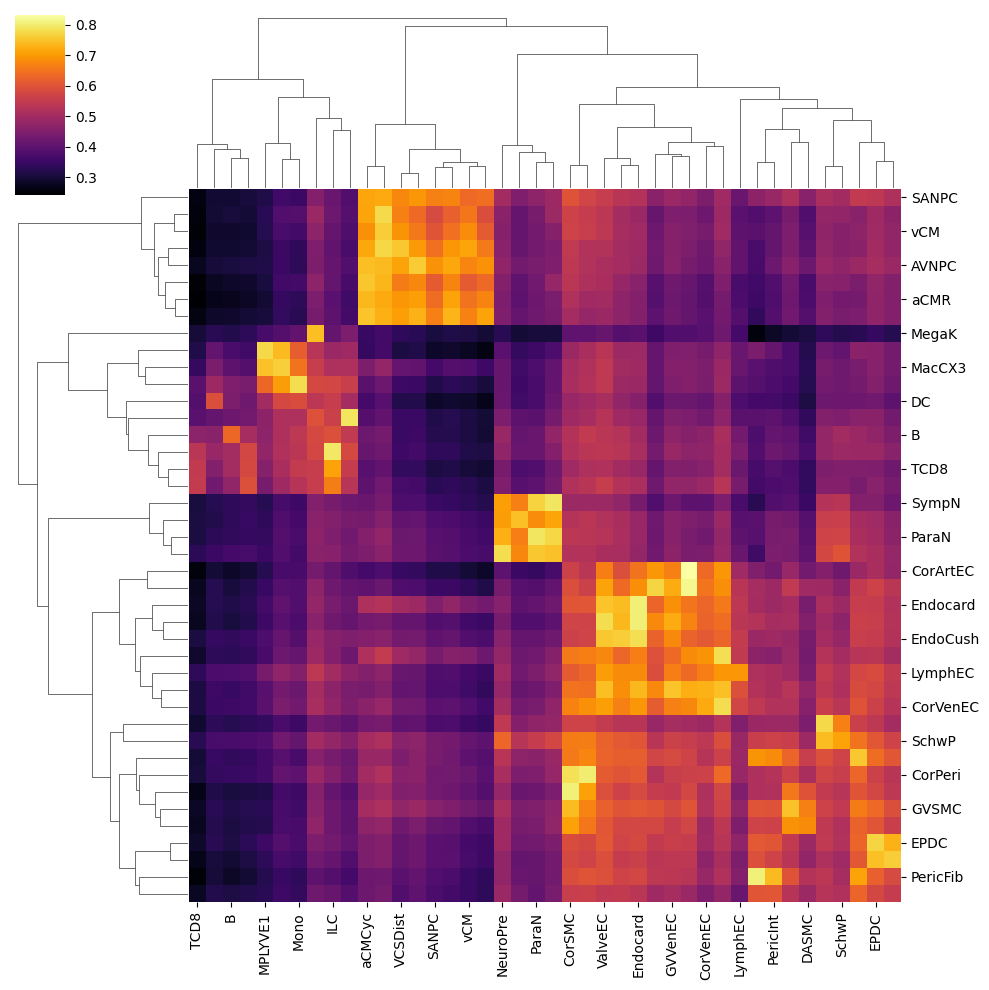

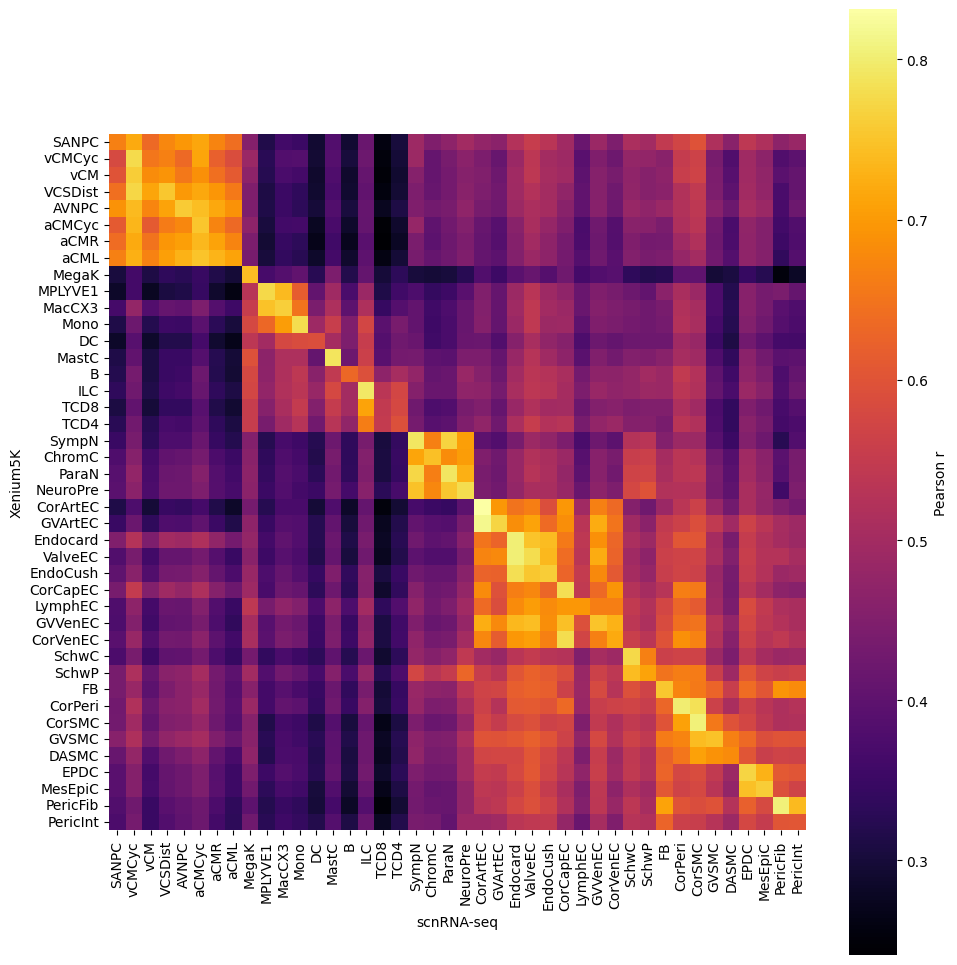

CPU times: user 2.05 s, sys: 252 ms, total: 2.3 s
Wall time: 2.54 s


In [52]:
%%time
figsize = (10,10)
cmap = 'inferno'
corr, pval = utils.df_pearson_corr_with_p_vectorized(query_df, ref_df, p_adjust='fdr_bh')

# draw the initial clustermap (for ordering only)
cg = sns.clustermap(
    corr,
    cmap=cmap,
    # center=0,
    metric='euclidean',
    method='average',
    figsize=figsize
)

# 4) extract the leaf order and reindex both matrices
order = cg.dendrogram_row.reordered_ind
labels = list(corr.index[order])

corr_ord = corr.loc[labels, labels]
pval_ord = pval.loc[labels, labels]

# 5) replot as a heatmap and annotate significance
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(
    corr_ord,
    cmap=cmap,
    # center=0,
    square=True,
    cbar_kws={'label': 'Pearson r'},
    ax=ax
)

'''
# add asterisks for p < 0.01
n = corr_ord.shape[0]
for i in range(n):
    for j in range(n):
        if pval_ord.iat[i, j] < 0.0001:
            ax.text(j + 0.5, i + 0.5, '*',
                    ha='center', va='center',
                    fontsize=10)
'''

ax.set_xticklabels(labels, rotation=90)
ax.set_xlabel('scnRNA-seq')
ax.set_yticklabels(labels, rotation=0)
ax.set_ylabel('Xenium5K')
plt.tight_layout()
plt.savefig(f'{figdir}/Xenium5K-vs-scnRNAseq_celltype-gex-corr.pdf', bbox_inches="tight",dpi=300)
plt.show()